In [6]:
import pandas as pd
import numpy as np

In [7]:
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

Prediction of the targets identified by Li et al. 2020 using the similarity between the CRISPR KO-induced gene expression signatures (from LINCS-L1000 screen) and influenza A-induced infection signature in Calu-3 cells (GSE37571).

## Read in data

In [8]:
gene_info = pd.read_table('../data/revision/crispr_screen/geneinfo_beta.txt')
sig_info = pd.read_table('../data/revision/crispr_screen/siginfo_beta.txt', low_memory=False)

## Info

In [9]:
sig_info = sig_info[sig_info['pert_type']=='trt_xpr']
selected_cols = ['sig_id', 'pert_type', 'pert_id',  'cmap_name', 'cell_iname', 'pert_itime']
sig_info = sig_info[selected_cols]
sig_info = sig_info.set_index('sig_id', drop = True)

In [10]:
sig_info.head()

,pert_type,pert_id,cmap_name,cell_iname,pert_itime
sig_id,,,,,
HAHN001_ES2_96H:G06,trt_xpr,HAHN-000061,AURKB,ES2,96 h
HAHN001_HCC44_96H:E15,trt_xpr,BRDN0001062183,RAC1,HCC44,96 h
HAHN001_HCC44_96H:K22,trt_xpr,BRDN0000734411,KIF11,HCC44,96 h
HAHN001_HCC44_96H:L09,trt_xpr,HAHN-000098,XBP,HCC44,96 h
HAHN001_HCC44_96H:H08,trt_xpr,HAHN-000086,ORC4,HCC44,96 h


In [11]:
# select landmark genes
fil = gene_info['feature_space']=='landmark'
genes_lm = gene_info[fil]
genes_lm = genes_lm.set_index('gene_id', drop = True)['gene_symbol']
genes_lm.index = genes_lm.index.astype(str)

# Consensus signatures

In [12]:
def calc_MODZ(data):
    """calculates MODZ weights based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation!"""
    if data.shape[1]==1:
        weights = np.array([1.0])
    elif data.shape[1]==2:
        weights = np.array([[0.5], [0.5]])
    else:
        CM = spearmanr(data)[0]
        fil = CM<0
        CM[fil] = 0.01
        weights = np.sum(CM, 1)-1
        weights = weights / np.sum(weights)
        weights = weights.reshape((-1, 1))
    return weights

In [ ]:
cmap_names = list(set(sig_info.cmap_name.dropna()))
signatures_lm = pd.DataFrame(index=genes_lm.index, columns=cmap_names)
lname = '../data/revision/crispr_screen/level5_beta_trt_xpr_n142901x12328.gctx'

for i in range(len(cmap_names)):
    cname = cmap_names[i]
    
    if i % 100 == 0:
        print(i, end = ',', flush=True)

    sample_ids = sig_info[sig_info['cmap_name']==cname].index
    gex_lm = parse(lname, cid=sample_ids,rid=genes_lm.index).data_df.loc[genes_lm.index]
        
    weights = calc_MODZ(gex_lm)
    gex_lm = pd.DataFrame(np.dot(gex_lm, weights), index=gex_lm.index, columns=[cname])
    
    signatures_lm[cname] = gex_lm[cname]
signatures_lm.to_csv('../data/revision/crispr_screen/signatures_lm.csv')
print('done')

## Calculate similarity

In [45]:
signatures_lm = pd.read_csv('../data/revision/crispr_screen/signatures_lm.csv', index_col = 0)

In [46]:
virus_signatures = pd.read_csv('../results/microarray_and_rnaseq_expression.csv', index_col=0)

In [47]:
# map gene names of CRISPR signatures
genes_lm.index = genes_lm.index.astype('int')
signatures_lm.index = signatures_lm.index.map(genes_lm.to_dict())

In [48]:
# filter 802 common genes
virus_signatures = virus_signatures[virus_signatures.index.isin(genes_lm)]
signatures_lm = signatures_lm[signatures_lm.index.isin(virus_signatures.index)]

In [49]:
virus_signatures = virus_signatures.loc[signatures_lm.index]

In [50]:
def calculate_similarity(drug_signatures, virus_signatures):
    correlation_df = pd.DataFrame(columns=drug_signatures.columns, index=virus_signatures.columns)
    genes = set(drug_signatures.index)&set(virus_signatures.index)
    drugs = drug_signatures.loc[genes]
    samples = virus_signatures.loc[genes]
    
    for drug in drugs.columns:
        for sample in samples.columns:
            correlation = spearmanr(drugs.loc[:,drug], samples.loc[:,sample])
            correlation_df.loc[sample, drug] = correlation[0]       
               
    return correlation_df

In [51]:
similarities_lm_genes = calculate_similarity(signatures_lm, virus_signatures)

In [53]:
similarities_lm_genes.to_csv('../data/revision/crispr_screen/similarities_landmark_genes.csv')

# Influenza A CRISPR

In [54]:
def get_common_genes(x,y):
    
    common_genes = set(x.index)&set(y.index)
    a = x.loc[common_genes].copy()
    b = y.loc[common_genes].copy()
    return a,b

In [73]:
samples = ['GSE37571_Calu3_Influenza']

In [74]:
iav = pd.read_excel('../data/revision/IAV_cripsr/41467_2019_13965_MOESM4_ESM_sd1.xlsx',
                    sheet_name='Secondary screen', index_col = 0)
iav = iav['screen p'].dropna()

In [75]:
similarities_lm_genes = pd.read_csv('../data/revision/crispr_screen/similarities_landmark_genes.csv', index_col = 0)
similarities_iav = similarities_lm_genes.T[samples]

In [76]:
iav,similarities_iav = get_common_genes(iav, similarities_iav)

In [77]:
sign_iav = pd.Series(0, index = iav.index)
sign_iav.loc[iav < 0.05] = 1

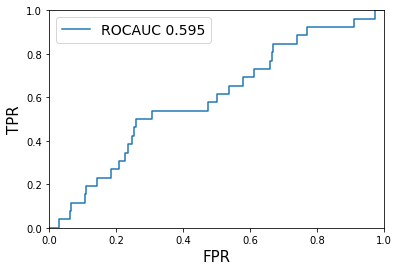

In [79]:
fpr, tpr, thresholds = roc_curve(sign_iav, similarities_iav.GSE37571_Calu3_Influenza)
auc = roc_auc_score(y_score=similarities_iav.GSE37571_Calu3_Influenza, y_true=sign_iav)

plt.plot(fpr, tpr, label = 'ROCAUC ' + str(round(auc, 3)))

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR',  fontsize=15)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize = 14)
plt.savefig('../figures/revision/IAV_CRISPR_similarity_ROC.pdf')
plt.savefig('../figures/revision/IAV_CRISPR_similarity_ROC.png', dpi = 100)

plt.show()
